# Demo: Predictive Maintenance 

https://aws.amazon.com/blogs/apn/how-to-orchestrate-a-data-pipeline-on-aws-with-control-m-from-bmc-software/


https://github.com/controlm/automation-api-community-solutions/tree/master/1-general-examples/use-case-predictive-maintenance



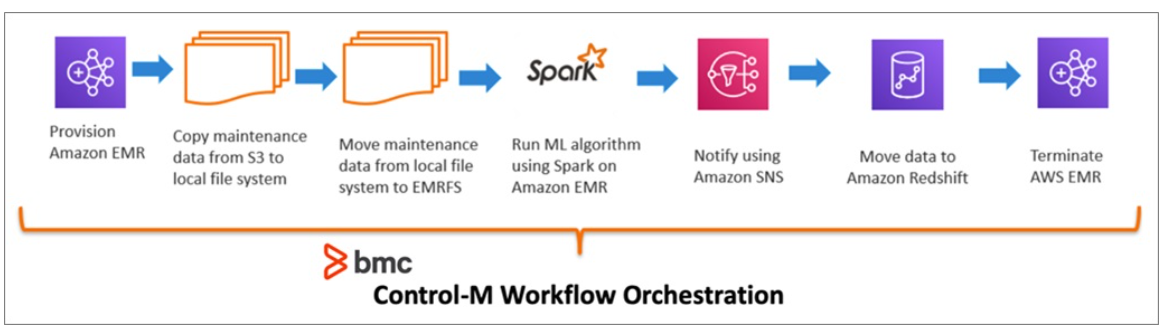

# Step 1 - Setup

## Step 1A - Install the library

In [ ]:
#!pip install git+https://github.com/controlm/ctm-python-client.git

## Step 1B- Import the library

In [ ]:
from ctm_python_client.core.bmc_control_m import CmJobFlow
from ctm_python_client.jobs.dummy import DummyJob
from ctm_python_client.jobs.command import CommandJob 
from ctm_python_client.jobs.script import ScriptJob 
from ctm_python_client.jobs.file_transfer import FileTransferJob 
from ctm_python_client.jobs.hadoop.hdfs_commands import HDFSCommandsJob
from ctm_python_client.jobs.hadoop.spark.scala_java import ScalaJavaJob
from ctm_python_client.jobs.database.embedded_query import EmbeddedQueryJob

# Step 2 - Flow level





## Step 2A - Create the Flow object

In [ ]:
# Create a file .secrets with the following three lines. One for uri, one for user and one for password.
"""
https://ip:8443/automation-api
username
password
"""

import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/.secrets", "r") as fp:
    ctm_uri = fp.readline().strip()
    ctm_user = fp.readline().strip()
    ctm_pwd = fp.readline().strip()

## Step 2B - Authenticate to Control-M

In [ ]:
from ctm_python_client.session.session import Session

session = Session(endpoint=ctm_uri, username=ctm_user, password=ctm_pwd)
session.get_token()

In [ ]:
t1_flow = CmJobFlow(
    application="Demo", sub_application="Demo-03", session=session, ctm_uri=ctm_uri)

## Step 2C - Define the Schedule

In [ ]:
t1_flow.set_run_as(username="ctmuser",host="host")

In [ ]:
# Define the schedule
months = ["JAN", "OCT", "DEC"]
monthDays = ["ALL"]
weekDays = ["MON","TUE", "WED", "THU", "FRI"]
fromTime = "0300"
toTime = "2100"
t1_flow.set_schedule(months, monthDays, weekDays,fromTime, toTime)


# Step 3  - Folder

## Step 3A - Create Folder

In [ ]:
# Create Folder
f1 = t1_flow.create_folder("PredictiveMaintenance")


### Define Variables

# Step 4 - Create Tasks

## Create Start and End Dummy Jobs

In [ ]:
start = t1_flow.add_job(f1, DummyJob(f1,"StartFlow"))
end = t1_flow.add_job(f1, DummyJob(f1,"EndFlow"))

## Create EMR Cluster

In [ ]:
IOT_Create_Cluster = ScriptJob(f1, "IOT_Create_Cluster", description = "Launch EMR cluster and deploy a Control-M agent",
                               pre_command=None, post_command=None,
                           file_name="launchEMR.bat", file_path="C:\\BMC_Stuff\\")
IOT_Create_Cluster_id = t1_flow.add_job(f1, IOT_Create_Cluster)

## Setup Dynamic EMR Agent

In [ ]:
IOT_CPSetup = ScriptJob(f1, "IOT_CPSetup", description = "Customize and deploy connection profiles for dynamic EMR agent",
                               pre_command=None, post_command=None,
                           file_name="FY19Seminar_CPDeploy.bat", file_path="C:\\BMC_Stuff\\")
IOT_CPSetup_id = t1_flow.add_job(f1, IOT_CPSetup)

## IOT Jar Setup

In [ ]:
file_transfers = [
        {
            "Src": "C:\\BMC_Stuff\\maintenance_data.csv",
            "Dest": "/home/hadoop/maintenance_data.csv",
            "TransferOption": "SrcToDest",
            "TransferType": "Ascii"
        },
        {
            "Src": "C:\\BMC_Stuff\\lr-assembly-1.0.jar",
            "Dest": "/home/hadoop/",
            "TransferOption": "SrcToDest"
        },
    ]
IOT_JAR_Setup = FileTransferJob(f1, "IOT_JAR_Setup", description = "Setting up Jar files",
                            connection_profile_src="controlm", 
                            connection_profile_dest="EMRhostSFTP",
				            number_of_retries=None,
				            s3_bucket_name=None,
				            file_transfers=file_transfers)
IOT_JAR_Setup_id = t1_flow.add_job(f1, IOT_JAR_Setup)

## Copy MaintenanceData to HDFS

In [ ]:

commands = [ {"copyFromLocal" : "-f /home/hadoop/maintenance_data.csv /user/hadoop/maintenance_data.csv"} ]
IOT_CopyMaintenanceData = HDFSCommandsJob(f1, "IOT_CopyMaintenanceData", 
                            connection_profile="PRDSPARK", commands=commands)
IOT_CopyMaintenanceData_id = t1_flow.add_job(f1, IOT_CopyMaintenanceData)

## IOT_ReadCSV

In [ ]:
arguments = [ "/user/hadoop/maintenance_data.csv", "/user/hadoop/maintenance_model" ]
preCommands = { "FailJobOnCommandFailure" :False, "Commands" : [ {"rm"  : "-f -R /user/hadoop/maintenance_model"} ] }
output = { "Operation": "Copy", "Destination": "/home/hadoop/ViJ.log" }

IOT_ReadCSV = ScalaJavaJob(f1, "IOT_ReadCSV", 
                            connection_profile="PRDSPARK",  program_jar="/home/hadoop//lr-assembly-1.0.jar",
                            main_class="com.bmc.lr.readCSV", arguments=arguments, 
                           pre_commands=preCommands,
                           post_commands=None,
                           spark_options=None 
                           #output=output,
                           )
IOT_ReadCSV_id = t1_flow.add_job(f1, IOT_ReadCSV)

## IOT ViJ Data

In [ ]:
file_transfers = [
        {
            "Src": "C:\\BMC_Stuff\\",
            "Dest": "/home/hadoop/ViJ.log",
            "TransferOption": "SrcToDest"
        }
    ]
IOT_ViJ_Data = FileTransferJob(f1, "IOT_ViJ_Data", description = "Setting up Jar files",
                            connection_profile_src="controlm", 
                            connection_profile_dest="EMRhostSFTP",
                            number_of_retries=None,
				            s3_bucket_name=None,
				            file_transfers=file_transfers)

IOT_ViJ_Data_id = t1_flow.add_job(f1, IOT_ViJ_Data)

## IOT_Redshift_SQL_Load

In [ ]:
IOT_Redshift_SQL_Load = EmbeddedQueryJob(f1, "IOT_Redshift_SQL_Load", 
                            connection_profile="PRDSPARK", 
                            query="copy telematics from 's3://bucket-name/TelematicsData' credentials 'aws_access_key_id=1234;aws_secret_access_key=45678' csv;")
IOT_Redshift_SQL_Load_id = t1_flow.add_job(f1, IOT_Redshift_SQL_Load)

## IOT_Notify

In [ ]:
IOT_Notify = CommandJob(f1, "IOT_Notify", description = "Notify owner that vehicle maintenance is required",
            command = "\"C:\\Program Files\\BMC Software\\Control-M EM\\Default\\bmcperl\\bin\\perl\" \"C:\\BMC_Stuff\\Publish.pl\" %%phone1 %%phone2")
IOT_Notify_id = t1_flow.add_job(f1, IOT_Notify)

## IOT_WaitAWhile

In [ ]:
IOT_WaitAWhile = CommandJob(f1, "IOT_WaitAWhile", description = "Wait 10 minutes to provide time for discussion",
            command = "powershell -command \"Start-Sleep -s 600\"")
IOT_WaitAWhile_id = t1_flow.add_job(f1, IOT_WaitAWhile)

## IOT_DeleteAgentfromHostgroup

In [ ]:
IOT_DeleteAgentfromHostgroup = CommandJob(f1, "IOT_DeleteAgentfromHostgroup", description = "Remove agent from hostgroup",
            command = "ctm config server:hostgroup:agent::delete controlm hadoop %%\\\\IOT_Pipeline\\EMRAGENT")
IOT_DeleteAgentfromHostgroup_id = t1_flow.add_job(f1, IOT_DeleteAgentfromHostgroup)

## IOT_DeleteAgentfromServer

In [ ]:
IOT_DeleteAgentfromServer = CommandJob(f1, "IOT_DeleteAgentfromServer", description = "Remove agent from server",
            command = "ctm config server:agent::delete controlm %%\\\\IOT_Pipeline\\EMRAGENT")
IOT_DeleteAgentfromServer_id = t1_flow.add_job(f1, IOT_DeleteAgentfromServer)

## IOT_Terminate_Cluster

In [ ]:
IOT_Terminate_Cluster = CommandJob(f1, "IOT_Terminate_Cluster", description = "Terminate EMR cluster",
            command = "\"C:\\Program Files\\BMC Software\\Control-M EM\\Default\\bmcperl\\bin\\perl\" \"C:\\BMC_Stuff\\terminateEMR.pl\" %%\\\\FY19AppDevDemo\\clusterID")
IOT_Terminate_Cluster_id = t1_flow.add_job(f1, IOT_Terminate_Cluster)

# Step 5 - Chain Tasks

In [ ]:
t1_flow.chain_jobs(f1,[start,IOT_Create_Cluster_id, IOT_CPSetup_id, IOT_JAR_Setup_id, IOT_CopyMaintenanceData_id, 
                      IOT_ReadCSV_id, IOT_Redshift_SQL_Load_id, IOT_ViJ_Data_id, IOT_Notify_id, IOT_WaitAWhile_id, 
                      IOT_DeleteAgentfromHostgroup_id, IOT_DeleteAgentfromServer_id, IOT_Terminate_Cluster_id,end])

# Step 6 - Display Workflow

## Step 6A - Display DAG

In [ ]:
# display using graphviz
from ctm_python_client.utils.displayDAG import DisplayDAG

# sudo apt-get install graphviz (on unix)
#  or
# brew install graphviz (for mac)
DisplayDAG(t1_flow).display_graphviz()

## Step 6B - Display JSON

In [ ]:
t1_flow.display_json()

# Step 7 - Submit Workflow to Control-M

In [ ]:
t1_flow.deploy()